In [41]:
import numpy as np
import matplotlib.pyplot as plt

from ohbemn import Solver, Region, ohpy, Orientation
from ohbemn.ohpy import wave, source

wave length: [98.67208743]
elements: 512


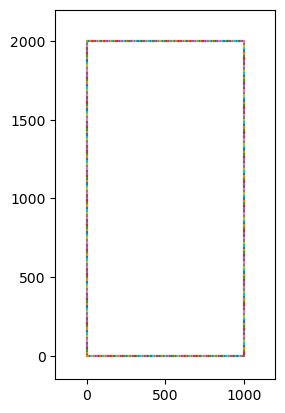

In [42]:
T = 8.   # [s]
f = 1/T
d = 40.  # [m]
c, cg, k = wave.wavec_interm(T, d)
k = k[0]
print("wave length:", c/f)

region = Region.rectangle(1000, 2000, 128, 128)

f, ax = plt.subplots()
region.plot(ax)
ax.set_xlim([-200, 1200])
ax.set_ylim([-150, 2200])
ax.set_aspect('equal')

print("elements:", region.len())

The breakwater is closed, except from 400 to 600 at y=0. Where it is closed it is defined by:

$\frac{\partial \phi}{\partial n} = 0$

which, since it is defined on the derivative of the velocity potential is a Neumann boundary condition. Where it is open, $\phi$ and $\partial \phi$ is defined by the source.

In [43]:
bc = region.neumann_boundary_condition()


centers = region.centers()
normals = region.normals()



In the interior, there is no other incoming field.

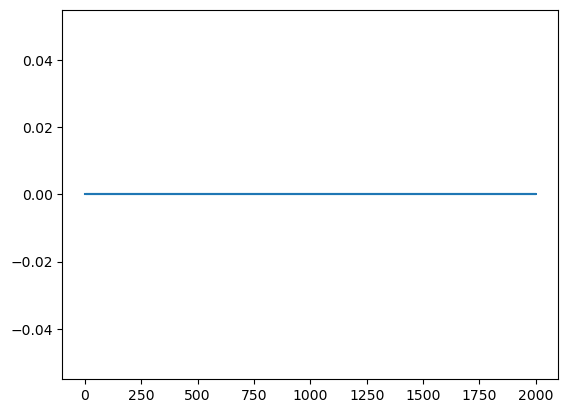

In [44]:
bi = region.boundary_incidence()

# Try to define incidence field
for i in range(region.len()):
    x = centers[i, :]
    n = normals[i, :]
    
    phi = source.plane(0, k, *x)
    v = source.dplane(0, k, *x, -n)
    
    # opening
    if x[1] < 0.1 and (x[0] >= 400. and x[0] <= 500.):    
        bc.beta[i] = 0.
        bc.alpha[i] = 1.
        

        bc.f[i] = 0
        bi.phi[i] = phi
        bi.v[i] = 0
    else:
        #bc.beta[i] = 0
        #bc.alpha[i] = 0
        if x[1] > 1999: # and x[0] > 0.1 and x[0] < 999:
            bc.f[i] = 0
            bc.alpha[i] = 1j*k
            bc.beta[i] = 1.
        elif x[1] < 0.1:
            bc.f[i] = 0
            bc.alpha[i] = 1j*k
            bc.beta[i] = 1.
        else:
            bc.f[i] = 0
            bc.alpha[i] = 1j*k
            bc.beta[i] = 1.

            #bc.f[i] = 0.
            #bc.beta[i] = 1.
            #bc.alpha[i] = 0.
            continue
            if x[0] > 500:
                bc.f[i] = 0
                bc.beta[i] = -1j*k
                bc.alpha[i] = 1.
            else:
                bc.f[i] = 0
                bc.beta[i] = 1j*k
                bc.alpha[i] = 1.

        
plt.figure()
plt.plot(centers[:,1], np.abs(bc.f))

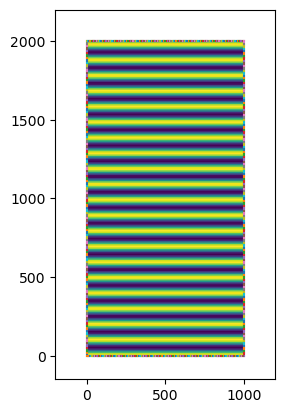

In [45]:
# Sample grid in the interior

x = np.arange(0.01, 999.1, 10)
y = np.arange(0.01, 1999.1, 10)
xx, yy = np.meshgrid(x, y)


# Incident field without break-water
fI = source.plane(0, k, xx, yy)

f, ax = plt.subplots()
region.plot(ax)
ax.set_xlim([-200, 1200])
ax.set_ylim([-150, 2200])
ax.set_aspect('equal')
ax.imshow(fI.real, origin='lower', extent=[0, 1000, 0, 2000])

In [46]:
# Solve boundary.

solver = Solver(region)
boundary_solution = solver.solve_boundary(Orientation.Interior, k, c, bc, bi)

computing boundary matrices..
solving linear equations..
done.


/tmp/ipykernel_340804/4066350755.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  boundary_solution = solver.solve_boundary(Orientation.Interior, k, c, bc, bi)


In [47]:
# Solve samples in interior
#x = np.arange(0, 200, 2)
#y = np.arange(0, 200, 2)
#xx, yy = np.meshgrid(x, y)
ep = np.vstack((xx.ravel(), yy.ravel())).T

print('Solving for interior points:', ep.shape)
eF = boundary_solution.solve_samples(np.zeros(ep.shape[0]), ep)

Solving for interior points: (20000, 2)


Text(0.5, 1.0, 'Breakwater (single slit) $\\Re\\{\\phi\\}$')

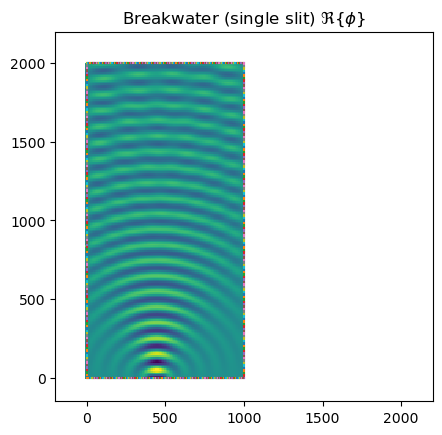

In [48]:
eFp = eF.phis.reshape(xx.shape)
f, ax = plt.subplots()
region.plot(ax)
ax.set_aspect('equal')
ax.pcolor(xx, yy, eFp.real, vmin=-1, vmax=1)
ax.set_xlim([-200, 2200])
ax.set_ylim([-150, 2200])
ax.set_title('Breakwater (single slit) $\\Re\\{\\phi\\}$')

In [49]:
f.savefig('figures/breakwater_closed_single_slit.png', dpi=250)